# Inspecting Online Inference

The goal of this tutorial is to demonstrate [callback functions](https://en.wikipedia.org/wiki/Callback_(computer_programming) for inspecting intermediate results in the sequential Monte Carlo loop of [`AutoGP.fit_smc!`](@ref). These callback functions can be used to inspect how the forecasts evolve as more data is incorporated in the model, obtain runtime versus accuracy profiles, and debug poorly performing inference, among many other use cases.

In [1]:
import AutoGP
import CSV
import Dates
import DataFrames
import Distributions

using AutoGP.GP
using PyPlot: plt

We begin by using functions from the [`AutoGP.GP`](@ref) module to generate synthetic data from a ground-truth Gaussian process time series model.

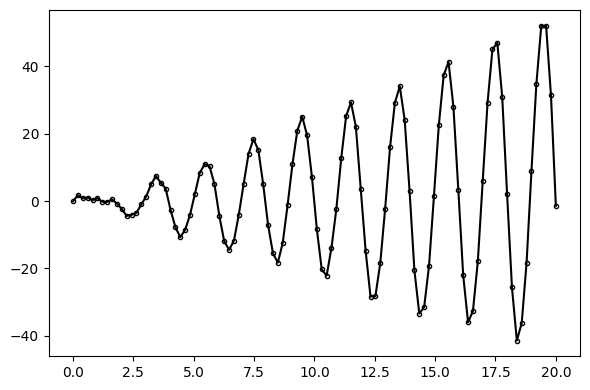

In [2]:
AutoGP.seed!(2)
cov = (Linear(1,0,50) * Periodic(5,2)) + GammaExponential(1,1)
noise = .1
n = 100

ds = Vector{Float64}(range(0, 20, length=n))
dist = Distributions.MvNormal(cov, noise, Float64[], Float64[], ds)
y = Distributions.rand(dist);

fig, ax = plt.subplots(figsize=(6, 4), dpi=100, tight_layout=true)
ax.plot(ds, y, marker=".", markerfacecolor="none", markeredgecolor="k", color="black");

We next initialize an [`AutoGP.GPModel`](@ref) instance with 8 particles. Recall that initializing a model does not fit it to the data.

In [3]:
model = AutoGP.GPModel(ds, y; n_particles=8);

We next define a callback that will be called at the end of each SMC inference. The callback function below, called `fn`, must take only keyword arguments (e.g., `axes`), as well as a varags specifier (`kwargs...`).  At each SMC step, the callback will be invoked and `kwargs` will be populated with various quantities, as documented in [`AutoGP.Callbacks.make_smc_callback`](@ref).  Some quantities used below include `kwargs[:step]`, which is the current SMC step; `kwargs[:elapsed]`, the total runtime in seconds; `kwargs[:model]`, which is the inferred `GPModel` at the current SMC step; `kwargs[:ds_next]` and `kwargs[:y_next]`, which are data that will be incorporated future SMC steps.  The observed data so far can be accessed via `(kwargs[:model].ds, kwargs[:model].y)`.

In order to generate plots at each step of inference, the signature of `fn` includes a parameter called `axes`, which is expected to be a `Dict` whose keys are integers (SMC steps) and values are `PyPlot.Axes` objects.  We will plot the in-sample and out-of-sample predictions at each step.

In [4]:
function fn(; axes::Dict, kwargs...)
    # Obtain SMC step, current model, and data to-be observed at later SMC steps
    step = kwargs[:step]
    model_step = kwargs[:model]
    ds_next = kwargs[:ds_next]
    y_next = kwargs[:y_next]
    
    # Generate predictions on observed data, to-be observed data, and future data.
    ds_query = vcat(model_step.ds, ds_next, (20:.1:30))
    predictions = AutoGP.predict(model_step, ds_query; quantiles=[0.025, 0.975])
    idx_sort = sortperm(ds_query)
    
    # Plot the observed data so far.
    ax = axes[step]
    ax.scatter(model_step.ds, model_step.y, marker="o", color="k", s=10, label="Observed Data")    
    if length(model_step.ds) > 0
        ax.axvline(maximum(model_step.ds), color="red", linestyle="--")
    end

    # Plot predictions on future data.
    for i=1:AutoGP.num_particles(model_step)
        subdf = predictions[predictions.particle.==i,:]
        ax.plot(subdf[idx_sort,:ds], subdf[idx_sort,:y_mean], linewidth=.5, color="k")
        ax.fill_between(
            subdf[idx_sort,:ds],
            subdf[idx_sort,"y_0.025"],
            subdf[idx_sort,"y_0.975"],
            color="tab:green",
            alpha=.05)
    end
    ax.legend(loc="upper left")
    ax.set_title("Step $(step), Obs $(length(model_step.ds)), Elapsed $(kwargs[:elapsed])")
    ax.set_ylim([-100, 100])
end

fn (generic function with 1 method)

Now that we have defined the callback `fn` we prepare the overall figure and `axes` dictionary.  To create the actual callback that will be provided to [`AutoGP.fit_smc!`](@ref) we use [`AutoGP.Callbacks.make_smc_callback`](@ref).

!!! note

    The `model` argument in the call to `make_smc_callback` is different than `kwargs[:model]` in the body of the callback `fn`.  The former `model` is obtained by initializing (but not fit fitting) `AutoGP.GPModel` on the full data in the global scope, whereas `kwargs[:model]` is a temporary `GPModel` that has been fitted to the observed data so far.

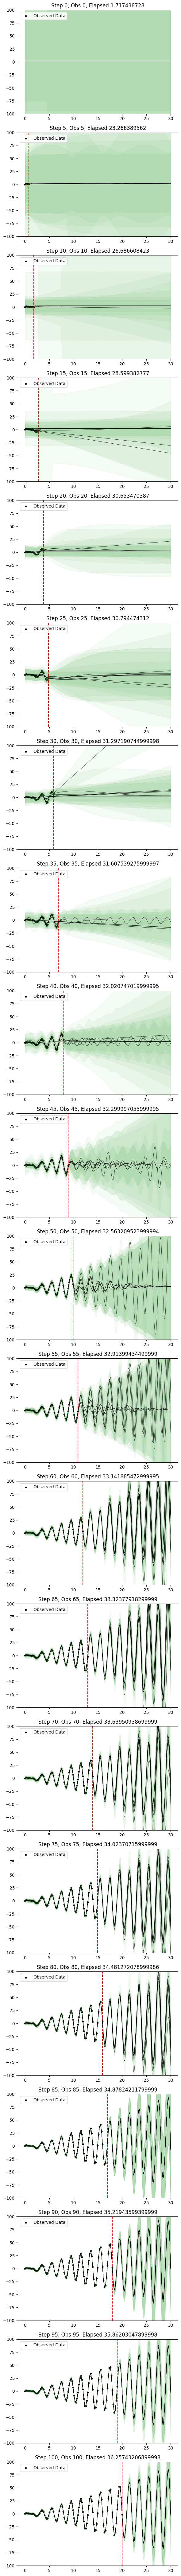

In [5]:
# Prepare the SMC schedule and intermediate plots
schedule = AutoGP.Schedule.linear_schedule(n, .05)
nrows = 1 + length(schedule)
fig, axes = plt.subplots(nrows=nrows, figsize=(6, 4*nrows), tight_layout=true, dpi=100)
axes = Dict(0=>axes[1], (step=>ax for (step, ax) in zip(schedule, axes[2:end]))...)

# Make the callback function.
callback_fn = AutoGP.Callbacks.make_smc_callback(fn, model; axes=axes)

# Perform inference.
AutoGP.fit_smc!(model, schedule, 10, 10; shuffle=false, callback_fn=callback_fn);

In [6]:
for k in AutoGP.covariance_kernels(model);
    display(k)
end

×
├── ＋
│   ├── GE(2.09, 1.32; 0.25)
│   └── PER(0.57, 0.20; 0.23)
└── ×
    ├── LIN(0.16; 0.11, 0.04)
    └── LIN(0.10; 0.28, 1.18)


×
├── ＋
│   ├── GE(2.09, 1.32; 0.25)
│   └── PER(0.57, 0.20; 0.23)
└── ×
    ├── LIN(0.16; 0.11, 0.04)
    └── LIN(0.10; 0.28, 1.18)


×
├── ＋
│   ├── GE(2.09, 1.32; 0.25)
│   └── PER(0.57, 0.20; 0.23)
└── ×
    ├── LIN(0.16; 0.11, 0.04)
    └── LIN(0.10; 0.28, 1.18)


×
├── ＋
│   ├── GE(2.09, 1.32; 0.25)
│   └── PER(0.57, 0.20; 0.23)
└── ×
    ├── LIN(0.16; 0.11, 0.04)
    └── LIN(0.10; 0.28, 1.18)


×
├── ＋
│   ├── GE(2.09, 1.32; 0.25)
│   └── PER(0.57, 0.20; 0.23)
└── ×
    ├── LIN(0.12; 0.19, 0.40)
    └── LIN(0.10; 0.28, 1.18)


×
├── ＋
│   ├── GE(5.19, 1.38; 0.62)
│   └── PER(0.57, 0.20; 0.23)
└── ×
    ├── LIN(0.12; 0.19, 0.40)
    └── LIN(0.06; 0.16, 0.44)


×
├── ＋
│   ├── GE(2.09, 1.32; 0.25)
│   └── PER(0.57, 0.20; 0.23)
└── ×
    ├── LIN(0.12; 0.19, 0.40)
    └── LIN(0.06; 0.16, 0.44)


×
├── ＋
│   ├── GE(2.09, 1.32; 0.25)
│   └── PER(0.57, 0.20; 0.23)
└── ×
    ├── LIN(0.12; 0.19, 0.40)
    └── LIN(0.10; 0.28, 1.18)
